# Visualization of vowel space density with convexhull

In this notebook, the vowel space densities and corresponding convexhull measures (at inputted density-cutoff) will be visualized for selected speakers across stress and language.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spa = pd.read_csv("data/spanish_vowels.csv")
eng = pd.read_csv("data/english_vowels.csv")

In [4]:
def images(df, participants, vowel_column, dens_cut, language):
    # subset of data with only speakers of interest
    df = df[df['Participant'].isin(participants)].copy()
        
    # define necessary functions and global variables
    ################################################################################
   
    def rem_outliers(df, vowel_column):
        print("Removal of outliers:")
        print("Initial length: ", len(df))
    
        # establish 25% and 75% for each formant
        f1_qrts = df.groupby(['Participant', vowel_column])["F1"].describe()[['25%', '75%']]
        f2_qrts = df.groupby(['Participant',vowel_column])["F2"].describe()[['25%', '75%']]
    
        # find interquartile range for each formant
        f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
        f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
        # determine upper limit for each formant
        f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
        f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
        # determine lower limit for each formant
        f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
        f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
        # create smaller df with only limits for each formant
        f1_limits = f1_qrts[['upper','lower']]
        f2_limits = f2_qrts[['upper','lower']]
    
        # merge limits into original df
        df = df.merge(f1_limits, left_on = ["Participant", vowel_column], right_index = True)
        df = df.merge(f2_limits, left_on = ["Participant", vowel_column], right_index = True, suffixes = ("_f1", "_f2"))
    
        # drop rows with outlier formants
        df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
        df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

        print("Final length: ", len(df))
        return df
    
    ####################################################################################
    # define function to scale all formant measures
    def scale_formants(df):
        medians = df.groupby(["Participant","is_stress"])[["F1", "F2"]].median()

        df = df.merge(medians, left_on = ["Participant","is_stress"], right_index = True, suffixes = ("","_med"))
        df["F1_vsd"] = (df["F1"]-df["F1_med"])/df["F1_med"]
        df["F2_vsd"] = (df["F2"]-df["F2_med"])/df["F2_med"]
        
        print("Formant data scaled")
        return df 
    
    ####################################################################################
    
    # define variable `grid`
    xvalues = np.flip(np.arange(-1., 1.01, 0.01))
    yvalues = np.arange(-1., 1.01, 0.01)

    grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
      
    #####################################################################################
    
    # define function get_density
    def density(grid, df):
        density_dict = {}
        for c in grid:
            # define x and y coordinate
            x = c[0]
            y = c[1]
    
            # define max and min coordinates that form a square of length 0.1 around the coordinate
            x_max = x + 0.05
            x_min = x - 0.05
            y_max = y + 0.05
            y_min = y - 0.05
    
            # pull a subset of data that fall within the box
            opts = df[(df["F2_vsd"] <= x_max) &
               (df["F2_vsd"] >= x_min) &
               (df["F1_vsd"] <= y_max) &
               (df["F1_vsd"] >= y_min)].copy()
            opts_list = list(zip(opts["F2_vsd"], opts["F1_vsd"]))
    
             # define density for this point
            dens = 0
    
            for o in opts_list:
                # define x and y coordinate of each point in my data
                o_x = o[0]
                o_y = o[1]
        
                # calculate distance to grid point
                dist = distance.euclidean([x, y], [o_x, o_y])
        
                if dist <= 0.05:
                    dens += 1
        
            density_dict[c] = dens
    
        # convert to df
        density_df = pd.DataFrame(density_dict.items())
        density_df = density_df.rename(columns = {0: "coord", 1:"density"})
    
        # make grid into df
        grid_df = pd.DataFrame(grid, columns=["x", "y"])
        grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
    
        # join df and grid_df
        grid_df = grid_df.join(density_df.set_index('coord'), on="coord")
              
        return grid_df
    
    ##################################################################################
    # remove outliers by participant, by task, by vowel
    df = rem_outliers(df, vowel_column)
    
    # Lobanov normalization of formants, by participant by task
    df = scale_formants(df)
    
    for i in participants:
        print("\n",i)
        
        # get subset of data for speaker across modality
        df_stress = df[(df["Participant"]==i) & (df["is_stress"]== 1)].copy()
        df_unstress = df[(df["Participant"]==i) & (df["is_stress"]!= 1)].copy()  
           
        # get density for each point across the modalities
        grid_stress_df = density(grid, df_stress)
        print("Densities calculated for stress")
        grid_unstress_df = density(grid, df_unstress)
        print("Densities calculated for unstress")
              
        # scale density measures
        grid_stress_df["density_norm"] = grid_stress_df["density"].apply(lambda x: x/grid_stress_df["density"].max())
        grid_unstress_df["density_norm"] = grid_unstress_df["density"].apply(lambda x: x/grid_unstress_df["density"].max())
        
        # pull out coordinates at specified density cutoff and get areas
        grid_stress_density = grid_stress_df[grid_stress_df["density_norm"] >= dens_cut].copy()
        grid_unstress_density = grid_unstress_df[grid_unstress_df["density_norm"] >= dens_cut].copy()
    
        points_tuples_stress = list(grid_stress_density["coord"])
        points_tuples_unstress = list(grid_unstress_density["coord"])
    
        points_stress = [list(k) for k in points_tuples_stress]
        points_unstress = [list(k) for k in points_tuples_unstress]
    
        hull_stress = ConvexHull(points_stress)
        hull_unstress = ConvexHull(points_unstress)
        
        # areas
        area_stress = hull_stress.area
        area_unstress = hull_unstress.area

        # format into heatmap plots
        stress_pivot = pd.pivot_table(grid_stress_df,
                    index='y',
                    values='density_norm',
                    columns='x')
        unstress_pivot = pd.pivot_table(grid_unstress_df,
                    index='y',
                    values='density_norm',
                    columns='x')
    
        # reindex column order to reflect standard representation of vowel formant space
        columns = stress_pivot.columns.tolist()
        columns = columns[::-1]
        
        stress_pivot = stress_pivot[columns]
        unstress_pivot = unstress_pivot[columns]
        
        # plot stress heatmap
        midpoint_stress = (stress_pivot.values.max() - stress_pivot.values.min()) / 2
        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(stress_pivot, cmap="viridis", center=midpoint_stress,
                         xticklabels = 25, yticklabels = 25)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = 13)
        cbar.ax.set_ylabel('Scaled Density', size=18)
        ax.set_xlabel('Normalized F2', fontsize = 20)
        ax.set_ylabel('Normalized F1', fontsize = 20)
        ax.set_title('%f' %area_stress, fontsize = 22)
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), fontsize = 13)
        ax.set_yticklabels(ax.yaxis.get_majorticklabels(), fontsize = 13, rotation = 0)
        plt.savefig('figs/'+language + str(i) + '_stress.svg', format='svg', dpi=10)
        print("Stress heatmap saved")
        
        # plot unstress heatmap
        midpoint_unstress = (unstress_pivot.values.max() - unstress_pivot.values.min()) / 2
        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(unstress_pivot, cmap="viridis", center=midpoint_unstress,
                         xticklabels = 25, yticklabels = 25)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = 13)
        cbar.ax.set_ylabel('Scaled Density', size=18)
        ax.set_xlabel('Normalized F2', fontsize = 20)
        ax.set_ylabel('Normalized F1', fontsize =20)
        ax.set_title('%f' %area_unstress, fontsize = 22)        
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), fontsize = 13)
        ax.set_yticklabels(ax.yaxis.get_majorticklabels(), fontsize = 13, rotation = 0)
        plt.savefig('figs/'+ language + str(i) + '_unstress.svg', format='svg', dpi=10)
        print("Unstress heatmap saved")
        
        # plot wd convexhull
        points_stress = np.array(points_stress)
        fig, ax = plt.subplots()
        for simplex in hull_stress.simplices:
            ax.plot(points_stress[simplex, 0], points_stress[simplex, 1], 'y-')
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        # invert x- and y- axes
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig('figs/' + language + str(i) + '_stress_convex.svg', format='svg', dpi=10, transparent=True)
        print("Stress convexhull saved")
        
        # plot interview convexhull
        points_unstress = np.array(points_unstress)
        fig, ax = plt.subplots()
        for simplex in hull_unstress.simplices:
            ax.plot(points_unstress[simplex, 0], points_unstress[simplex, 1], 'y-')
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        # invert x- and y- axes
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig('figs/' + language + str(i) + '_unstress_convex.svg', format='svg', dpi=10, transparent=True)
        print("Unstress convexhull saved")

Removal of outliers:
Initial length:  53560
Final length:  48599
Formant data scaled

 p113
Densities calculated for stress
Densities calculated for unstress
Stress heatmap saved
Unstress heatmap saved
Stress convexhull saved
Unstress convexhull saved

 p121
Densities calculated for stress
Densities calculated for unstress
Stress heatmap saved
Unstress heatmap saved
Stress convexhull saved
Unstress convexhull saved


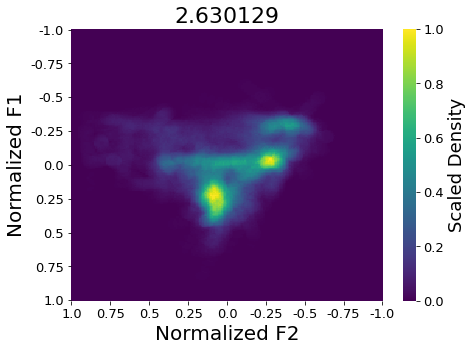

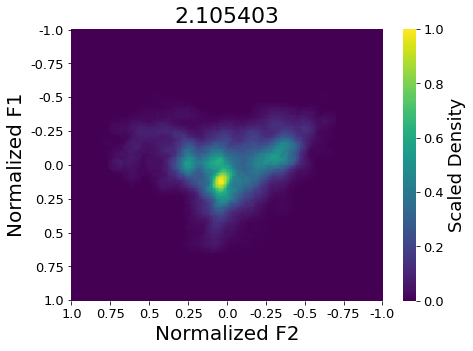

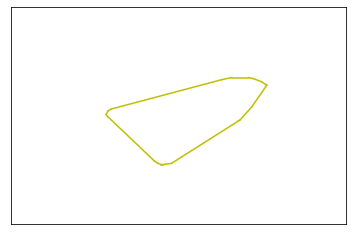

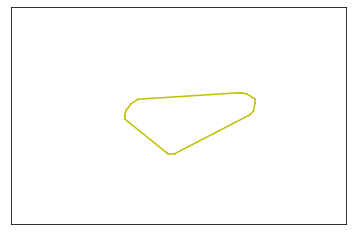

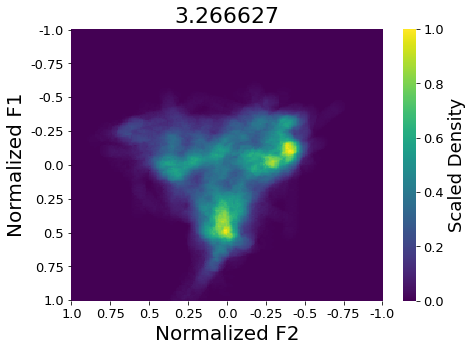

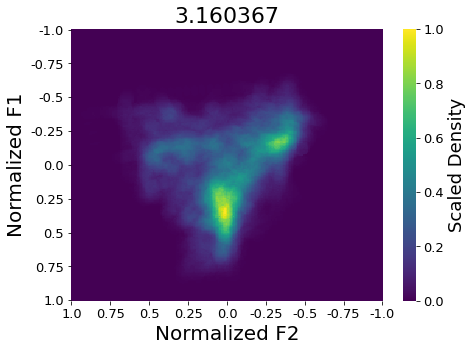

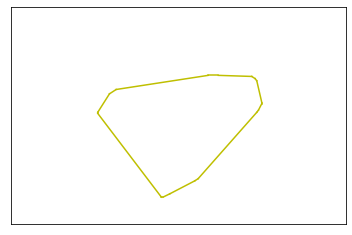

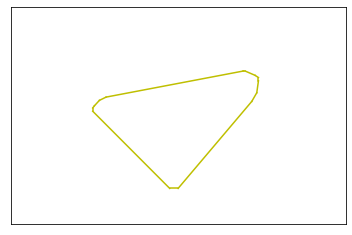

In [5]:
participants = ["p113", "p121"]
images(spa, participants, "Vowel", 0.25, "spa")

Removal of outliers:
Initial length:  2903
Final length:  2670
Formant data scaled

 p113
Densities calculated for stress
Densities calculated for unstress
Stress heatmap saved
Unstress heatmap saved
Stress convexhull saved
Unstress convexhull saved

 p121
Densities calculated for stress
Densities calculated for unstress
Stress heatmap saved
Unstress heatmap saved
Stress convexhull saved
Unstress convexhull saved


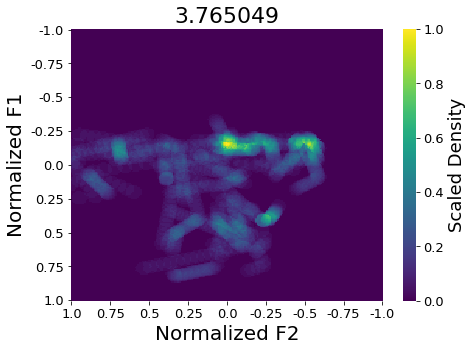

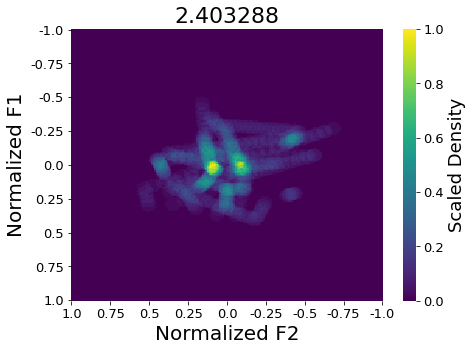

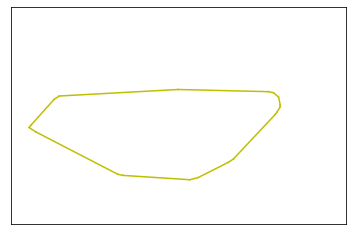

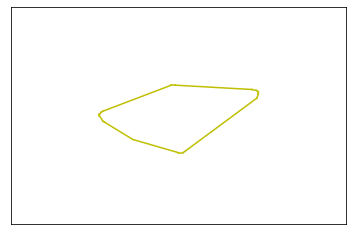

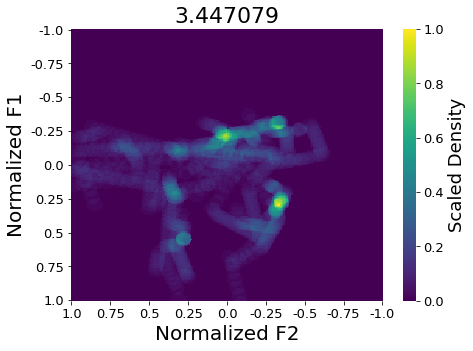

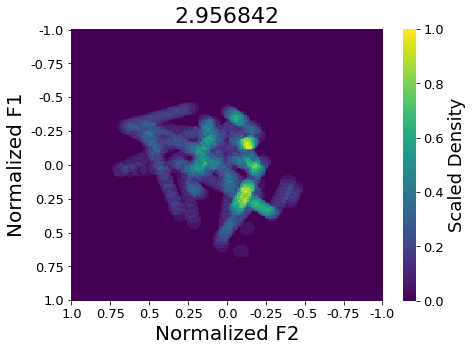

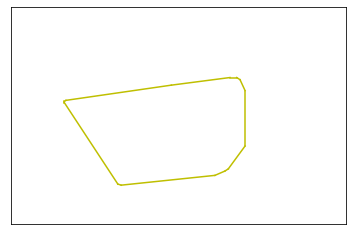

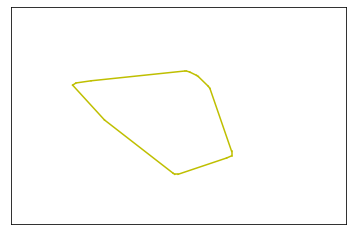

In [6]:
participants = ["p113", "p121"]
images(eng, participants, "Vowel", 0.25, "eng")